In [6]:
# C++ code @ https://github.com/abin24/Saliency-detection-toolbox

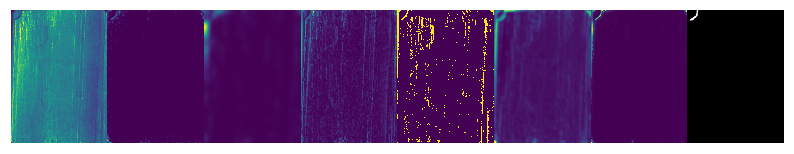

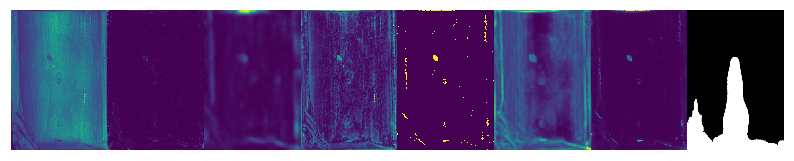

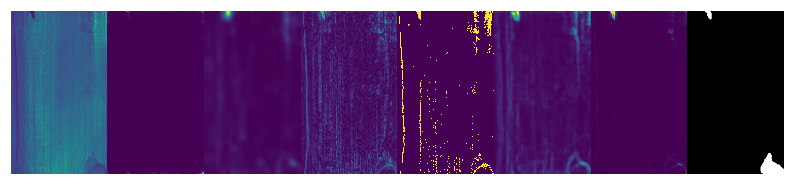

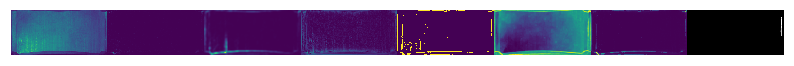

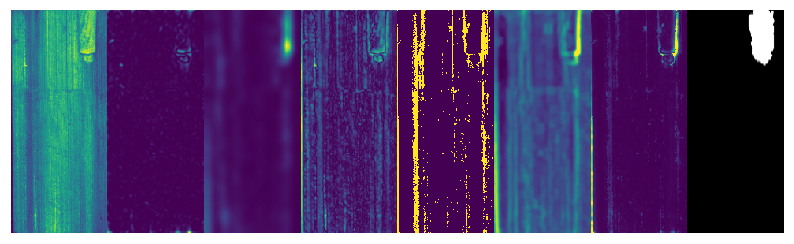

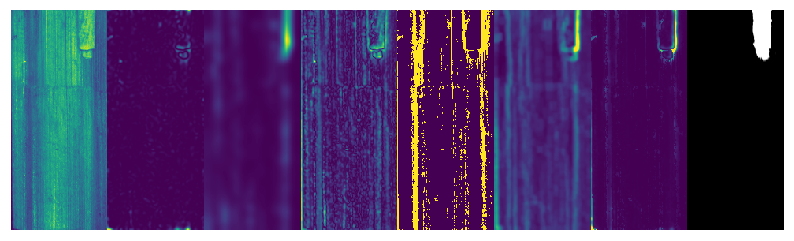

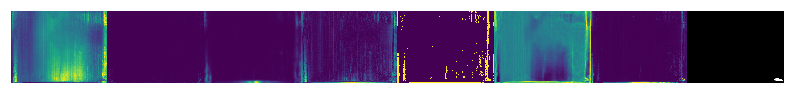

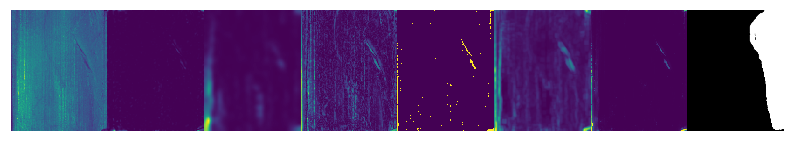

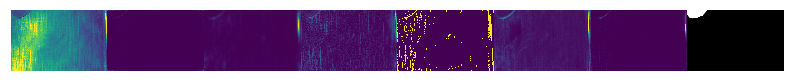

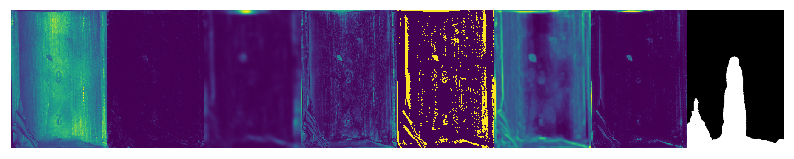

each used %.2f s 0.16323632632984836


In [6]:
"""
Created on Tue Dec 10 21:08:30 2017
Author: Yibin Huang, Congying Qiu

Paper: Surface Defect Saliency of Magnetic Tile
Preprint: https://www.researchgate.net/publication/325882869_Surface_Defect_Saliency_of_Magnetic_Tile
"""

import numpy as np
import time
import glob
import cv2

from skimage.color import rgb2lab

import matplotlib.pyplot as plt
%matplotlib inline

def plot_ims(data, alpha=True, cmap=None, ncols=None, nrows=None, ): # plot_images(12)
    """
    Expects numpy array with channels last or list
    """
    if not nrows: nrows = 1
    
    if type(data) == list:
#         nrows = 1
        if not ncols: ncols = len(data)
    else:
        if len(data.shape[:1]) == 3: ncols = 1
        else: ncols = data.shape[0] // nrows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(11, 10)
    fig.tight_layout()
    
    for i, ax in enumerate(axes.flat):
        if len(data[i].shape) == 2: 
            data_ = data[i].astype(np.uint8)
            im = ax.imshow(data_, cmap=cmap)
        elif (data[i].shape[2] == 4):
            if alpha: 
                data_ = data[i].astype(np.uint8)
                im = ax.imshow(data_[:,:,[2,1,0,3]], cmap=cmap)
            else: 
                data_ = data[i].astype(np.uint8)
                im = ax.imshow(data_[:,:,[2,1,0]], cmap=cmap)
        elif (data[i].shape[2] == 3): 
            data_ = data[i].astype(np.uint8)
            im = ax.imshow(data_[:,:,[2,1,0]], cmap=cmap)
        else: 
            print('Data dimensions not supported')
        
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, hspace=0, wspace=0)
#     plt.tight_layout()
    plt.show()

########################################
# Existing image processing methods
########################################

def strukturtrnsor(inp, dsize=4, sigma=-1):     
    height, width=inp.shape[:2]
    gray_img=cv2.resize(inp, (int(width/dsize), int(height/dsize)))

    Ix=cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=3)
    Iy=cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=3)

    Ix2=cv2.GaussianBlur(Ix*Ix, (5,5), sigma)
    Iy2=cv2.GaussianBlur(Iy*Iy, (5,5), sigma)
    Ixy=cv2.GaussianBlur(Ix*Iy, (5,5), sigma)    

    A=(Ix2 - Iy2) * (Ix2 - Iy2) + 4 * Ixy * Ixy
    B=Ix2 + Iy2     
    cv2.normalize(A, A, 0, 1.0, cv2.NORM_MINMAX)
    cv2.normalize(B, B, 0, 1.0, cv2.NORM_MINMAX)
    dst=(A + B) / 2  
    dst=cv2.resize(dst, (width,height))
    dst=dst.astype('float32')

    return dst

def PHOT(inp): 
    # 2D Discrete Fourier Transform (DFT) is used to find the frequency domain
    dft=cv2.dft(np.float32(inp),flags=cv2.DFT_COMPLEX_OUTPUT)
    MAG, PHASE=cv2.cartToPolar(dft[:,:,0],dft[:,:,1])    
    dft[:, :, 0]=dft[:, :, 0] / MAG
    dft[:,:,1]=dft[:,:,1] / MAG
    
    img_back=cv2.idft(dft)
    MAG =img_back[:,:,0]
    MAG=cv2.GaussianBlur(MAG,(9,9),0)
    m=np.mean(MAG)
    MAG=(MAG-m)*(MAG-m)
    cv2.normalize(MAG,MAG,0,1.0,cv2.NORM_MINMAX)

    return MAG.astype('float32')

     
def AC(inp, R1=0, Scale=3):   
    # the input is an uint8 1 channel img,only For gray_img now
    imgf=np.float32(inp)
    Height, Width=inp.shape[:2]
    MeanR1=cv2.GaussianBlur(imgf, (3, 3), -1)

    # R1=0 -> use the the original pixel
    if R1 > 0:      
        MeanR1=cv2.GaussianBlur(MeanR1,(7,7),-1)
        
    MinR2=min(Width, Height) / 8
    MaxR2=min(Width, Height) / 2  
    
    out=0
    for Z in range(Scale):       
        MeanR2=MeanR1
        radius=int((MaxR2 - MinR2) * Z / (Scale - 1) + MinR2)
        if  radius % 2 == 0:
            radius += 1
        MeanR2=cv2.GaussianBlur(MeanR1, (radius, radius), -1)
        out += np.sqrt((MeanR2-MeanR1) * (MeanR2-MeanR1)) 
        out=out.astype('float32')
    
    cv2.normalize(out, out, 0, 1.0, cv2.NORM_MINMAX)
    
    return out


def Darker(inp):
    return cv2.adaptiveThreshold(inp,255.0,cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV,35,15)


def activate_boolean_map(bool_map, dilation_width=7):
    """       
        Performs activation on a single boolean map.
    """
    # use the boolean map as a mask for flood filling
    activation=np.array(bool_map, dtype=np.uint8)
    mask_shape=(bool_map.shape[0] + 2, bool_map.shape[1] + 2)
    ffill_mask=np.zeros(mask_shape, dtype=np.uint8)

    # top and bottom rows
    for i in range(0, activation.shape[0]):
        for j in [0, activation.shape[1] - 1]:
            if activation[i,j]:
                cv2.floodFill(activation, ffill_mask, (j, i), 0)

    # left and right columns
    for i in [0, activation.shape[0] - 1]:
        for j in range(0, activation.shape[1]):
            if activation[i,j]:
                cv2.floodFill(activation, ffill_mask, (j, i), 0)

    ret=activation!=1
    map1=ret * bool_map
    map2=ret * (1-bool_map)
    kernal=np.ones((dilation_width,dilation_width),np.uint8);
    
    if  dilation_width > 0:
        map1 = cv2.dilate(map1.astype('uint8'),kernal,1)
        map2 = cv2.dilate(map2.astype('uint8'),kernal,1)
    activation=(map1+map2)/2
    
    return activation


def BMS(src, n_thresholds=80):
    """
        Computes Boolean Map Saliency (BMS).
    """
    src=cv2.GaussianBlur(src, (5, 5), -1) 
    if  src.ndim>2 :
        img_lab=rgb2lab(src)
    else:
        img_lab=cv2.cvtColor(src,cv2.COLOR_GRAY2BGR)
        
    img_lab=cv2.medianBlur(img_lab,3).astype('float')   

    cv2.normalize(img_lab,img_lab,0,1.0,cv2.NORM_MINMAX)   
    thresholds=np.arange(0, 1, 1.0 / n_thresholds)[1:]    
    
    # compute boolean maps
    bool_maps=[]
    
    for thresh in thresholds:
        img_lab_T=img_lab.transpose(2, 0, 1)
        img_thresh=(img_lab_T > thresh)
        bool_maps.extend(list(img_thresh))
            
    # compute mean attention map
    attn_map=np.zeros(img_lab.shape[:2], dtype=np.float)
   
    for bool_map in bool_maps:
        attn_map += activate_boolean_map(bool_map)
 
    attn_map /= n_thresholds
    cv2.normalize(attn_map,attn_map,0,1.1,cv2.NORM_MINMAX)
    attn_map=attn_map*attn_map
    attn_map=cv2.GaussianBlur(attn_map, (5, 5), -1)    
    
    attn_map[attn_map > 1]=1
    
    return attn_map.astype('float')    
 
    
#######
# MCue
#######
    
def Mcue2(src):
    dstphot=PHOT(src)        
    dststrukturtrnsor=strukturtrnsor(src)
    dstac=AC(src)
    dstdarker=Darker(src)
    dstBMS=BMS(src)
    dstdarker=dstdarker/255*3.0+1.0    
    mcue2=(dstBMS*dstdarker*(dstphot*3+dstac+dststrukturtrnsor))/4.0*255.0
    mcue2[mcue2 > 255]=255
    
    return mcue2.astype('uint8')
    
    
#  test the mcue
def testMCue(srcpath='/<path_to_project>/imgs'):
    data_type='jpg'
    imgs= glob.glob(srcpath+"/*."+data_type)
    tic=time.time() 
    
    # test above image processing methods
    for imgname in imgs[:10]:
        src=cv2.imread(imgname,cv2.IMREAD_GRAYSCALE)    
        dstphot=PHOT(src)        
        dststrukturtrnsor=strukturtrnsor(src)
        dstac=AC(src)
        dst_darker=Darker(src)
        dstBMS=BMS(src)
        mc2=Mcue2(src)
       
        # compare the performance of Mcue2 and selected method. Replace the item needed for visualization: 
        rsimg= np.concatenate((dst_darker/255, dstBMS), axis=1)*255
        
#         cv2.imshow("rsimg",rsimg.astype('uint8'))
#         cv2.imshow("mc2",mc2)
#         cv2.waitKey() 
    
        # Loading the label an plotting
        label_path = srcpath + imgname.split('/')[-1].split('.jpg')[0] + '.png'
        label = cv2.imread(label_path) 
        plot_ims([src, dstphot * 255, dststrukturtrnsor * 255, dstac * 255, \
                  dst_darker, dstBMS * 255, mc2, label])
#         plot_ims([rsimg, mc2])

    toc=time.time()
    
    used=(toc-tic)/len(imgs)
    print("each used %.2f s",used)
#     cv2.destroyAllWindows()
    
    return src, dstphot, dststrukturtrnsor, dstac, dst_darker, dstBMS, mc2, label
    
if __name__ == '__main__':
    src, dstphot, dststrukturtrnsor, dstac, dst_darker, dstBMS, mc2, label = \
    testMCue('../data/Magnetic-tile-defect-datasets.-master/MT_Break/Imgs/')

#### Visualizing each method 
#### strukturtrnsor

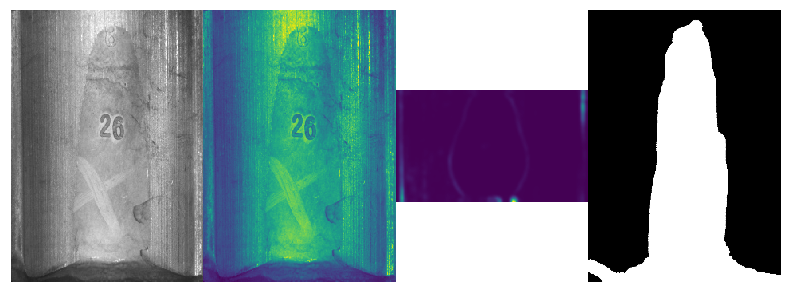

each used %.2f s 0.010351002216339111


In [13]:
# dataloader
gpath = 'data/Magnetic-tile-defect-datasets.-master/MT_Fray/Imgs/'
data_type='jpg'
imgs= glob.glob(gpath+"/*."+data_type)
tic=time.time() 
for i in imgs[:1]:
    im = cv2.imread(i) 
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE) 
    # Loading the label an plotting
    label_path = gpath + i.split('/')[-1].split('.jpg')[0] + '.png'
    label = cv2.imread(label_path) 
    plot_ims([im, img, dststrukturtrnsor * 255, label])

    toc=time.time()
    used=(toc-tic)/len(imgs)
    print("each used %.2f s",used)

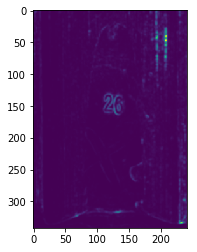

In [47]:
inp = im
dsize = 4
sigma = -1  
height, width = inp.shape[:2]

gray_img = inp
# cv2.resize(inp, (int(width/dsize), int(height/dsize)))

Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

Ix2 = cv2.GaussianBlur(Ix*Ix, (5,5), sigma)
Iy2 = cv2.GaussianBlur(Iy*Iy, (5,5), sigma)
Ixy = cv2.GaussianBlur(Ix*Iy, (5,5), sigma)    

A = (Ix2 - Iy2) * (Ix2 - Iy2) + 4 * Ixy * Ixy
B = Ix2 + Iy2     
cv2.normalize(A, A, 0, 1.0, cv2.NORM_MINMAX)
cv2.normalize(B, B, 0, 1.0, cv2.NORM_MINMAX)
dst = (A + B) / 2  
dst = cv2.resize(dst, (width,height))
dst = dst.astype('float32')

plt.imshow(dst)

(342, 242, 2)

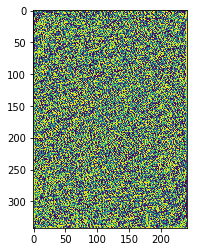

In [53]:
# PHOT(inp)
# 2D Discrete Fourier Transform (DFT) is used to find the frequency domain
inp = img
dft = cv2.dft(np.float32(inp), flags=cv2.DFT_COMPLEX_OUTPUT)
MAG, PHASE = cv2.cartToPolar(dft[:,:,0],dft[:,:,1])    
dft[:, :, 0] = dft[:, :, 0] / MAG
dft[:,:,1] = dft[:,:,1] / MAG
    
img_back=cv2.idft(dft)
MAG = img_back[:,:,0]
MAG = cv2.GaussianBlur(MAG,(9,9),0)
m = np.mean(MAG)
MAG = (MAG-m)*(MAG-m)
cv2.normalize(MAG, MAG, 0, 1.0, cv2.NORM_MINMAX)

plt.imshow(dft[:,:,1])

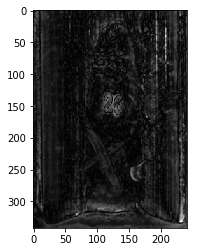

In [60]:
# AC 
R1=0
Scale=3
inp = im

# the input is an uint8 1 channel img,only For gray_img now
imgf = np.float32(inp)
Height, Width = inp.shape[:2]
MeanR1 = cv2.GaussianBlur(imgf, (3, 3), -1)

# R1=0 -> use the the original pixel
if R1 > 0: MeanR1=cv2.GaussianBlur(MeanR1,(7,7),-1)
        
MinR2=min(Width, Height) / 8
MaxR2=min(Width, Height) / 2  
    
out=0
for Z in range(Scale):       
    MeanR2=MeanR1
    radius=int((MaxR2 - MinR2) * Z / (Scale - 1) + MinR2)
    if  radius % 2 == 0: radius += 1
    MeanR2=cv2.GaussianBlur(MeanR1, (radius, radius), -1)
    out += np.sqrt((MeanR2-MeanR1) * (MeanR2-MeanR1)) 
    out=out.astype('float32')
    
cv2.normalize(out, out, 0, 1.0, cv2.NORM_MINMAX)

plt.imshow(out)

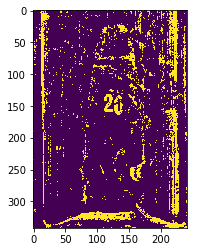

In [56]:
# Darker(inp)
inp = img
dim = cv2.adaptiveThreshold(inp, 255.0, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 35, 15)

plt.imshow(dim)

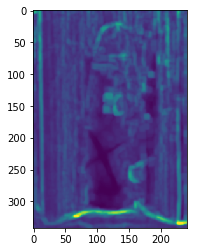

In [62]:
# BMS
n_thresholds = 80
src = img

# Computes Boolean Map Saliency (BMS).
src = cv2.GaussianBlur(src, (5, 5), -1) 
if  src.ndim>2 : img_lab=rgb2lab(src)
else: img_lab=cv2.cvtColor(src,cv2.COLOR_GRAY2BGR)
        
img_lab=cv2.medianBlur(img_lab,3).astype('float')   

cv2.normalize(img_lab,img_lab,0,1.0,cv2.NORM_MINMAX)   
thresholds=np.arange(0, 1, 1.0 / n_thresholds)[1:]    
    
# compute boolean maps
bool_maps=[]
    
for thresh in thresholds:
    img_lab_T=img_lab.transpose(2, 0, 1)
    img_thresh=(img_lab_T > thresh)
    bool_maps.extend(list(img_thresh))
            
# compute mean attention map
attn_map=np.zeros(img_lab.shape[:2], dtype=np.float)
   
for bool_map in bool_maps: attn_map += activate_boolean_map(bool_map)

attn_map /= n_thresholds
cv2.normalize(attn_map,attn_map,0,1.1,cv2.NORM_MINMAX)
attn_map=attn_map*attn_map
attn_map=cv2.GaussianBlur(attn_map, (5, 5), -1)    
    
attn_map[attn_map > 1]=1
    
attn_map = attn_map.astype('float')  

plt.imshow(attn_map)